In [30]:
import numpy as np
import MDP
import matplotlib.pyplot as plt

class RL2:
  def __init__(self,mdp,sampleReward):
    '''Constructor for the RL class

    Inputs:
    mdp -- Markov decision process (T, R, discount)
    sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
    This function takes one argument: the mean of the distributon and
    returns a sample from the distribution.
    '''

    self.mdp = mdp
    self.sampleReward = sampleReward

  def sampleRewardAndNextState(self,state,action):
    '''Procedure to sample a reward and the next state
    reward ~ Pr(r)
    nextState ~ Pr(s'|s,a)

    Inputs:
    state -- current state
    action -- action to be executed

    Outputs:
    reward -- sampled reward
    nextState -- sampled next state
    '''

    reward = self.sampleReward(self.mdp.R[action,state])
    cumProb = np.cumsum(self.mdp.T[action,state,:])
    nextState = np.where(cumProb >= np.random.rand(1))[0][0]
    return [reward,nextState]
  def qLearning(self,s0,initialQ,nEpisodes,nSteps,epsilon=0,temperature=0):
    trial = 100
    avg_cul_rewards = np.zeros(nEpisodes)

    alpha = 0.1 # learning rate

    for i in range(trial):
      Q = initialQ.copy()
      policy = np.zeros(self.mdp.nStates,int)
      cumulative_rewards = np.zeros(nEpisodes)

      for episode in range(nEpisodes):
        currentState = s0
        for j in range(nSteps):
          act = np.argmax(Q[:, currentState])
          # Epsilon exploration
          if(epsilon > 0):
            if(np.random.rand() <= epsilon):
              act = np.random.randint(self.mdp.nActions)
          # Boltzmann exploration
          else:
            if(temperature > 0):
              all_act = Q[:, currentState]/temperature
              boltz_prob = (np.exp(all_act) / np.sum(np.exp(all_act)))
              act = np.random.choice(np.arange(self.mdp.nActions), p=boltz_prob)
          # 執行action
          reward, nextState = self.sampleRewardAndNextState(currentState, act)
          # 更新Q-table
          Q[act, currentState] = Q[act, currentState] + alpha * (reward + (self.mdp.discount * np.max(Q[:, nextState])) - Q[act, currentState])
          policy[currentState] = act
          currentState = nextState
          # 累加discounted reward
          cumulative_rewards[episode] += (np.power(self.mdp.discount, j) * reward)
      avg_cul_rewards += cumulative_rewards
    avg_cul_rewards = avg_cul_rewards / trial

    xAxis = range(1, (len(avg_cul_rewards)+1))
    yAxis = avg_cul_rewards
    pltLabel = "Q Learning"
    plt.plot(xAxis, yAxis, label= pltLabel)

    return [Q,policy]

  def modelBasedRL(self,s0,defaultT,initialR,nEpisodes,nSteps,epsilon=0):
    '''Model-based Reinforcement Learning with epsilon greedy
    exploration.  This function should use value iteration,
    policy iteration or modified policy iteration to update the policy at each step

    Inputs:
    s0 -- initial state
    defaultT -- default transition function when a state-action pair has not been vsited
    initialR -- initial estimate of the reward function
    nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
    nSteps -- # of steps per episode
    epsilon -- probability with which an action is chosen at random

    Outputs:
    V -- final value function
    policy -- final policy
    '''



    trial = 100
    avg_cul_rewards = np.zeros(nEpisodes)

    for i in range(trial):
      N_sa = np.zeros(self.mdp.R.shape)
      N_sas = np.zeros(self.mdp.T.shape)
      R = initialR.copy()
      T = defaultT.copy()
      V = np.zeros(self.mdp.nStates)
      policy = np.zeros(self.mdp.nStates,int)
      cumulative_rewards = np.zeros(nEpisodes)

      for episode in range(nEpisodes):
        currentState = s0
        for j in range(nSteps):
          learned_mdp = MDP.MDP(T, R, self.mdp.discount)
          policy, V, _, _ = learned_mdp.modifiedPolicyIteration(initialPolicy=policy, initialV=V)

          # Epsilon exploration
          act = policy[currentState]
          if(epsilon > 0):
            if(np.random.rand() <= epsilon):
              act = np.random.randint(self.mdp.nActions)

          # 執行action
          reward, nextState = self.sampleRewardAndNextState(currentState, act)
          # 更新model
          N_sa[act, currentState] += 1
          N_sas[act, currentState, nextState] += 1
          T[act, currentState, :] = N_sas[act, currentState, :] / N_sa[act, currentState]
          R[act, currentState] += ((1 / N_sa[act, currentState]) * (reward - R[act, currentState]))

          currentState = nextState
          # 累加discounted reward
          cumulative_rewards[episode] += (np.power(self.mdp.discount, j) * reward)
      avg_cul_rewards += cumulative_rewards
    avg_cul_rewards = avg_cul_rewards / trial

    xAxis = range(1, (len(avg_cul_rewards)+1))
    yAxis = avg_cul_rewards
    pltLabel = "Model Based RL"
    plt.plot(xAxis, yAxis, label= pltLabel)

    learned_mdp = MDP.MDP(T, R, self.mdp.discount)
    policy, V, _, _ = learned_mdp.modifiedPolicyIteration(initialPolicy=policy, initialV=V)

    return [V,policy]

  def epsilonGreedyBandit(self,nIterations):
    '''Epsilon greedy algorithm for bandits (assume no discount factor).  Use epsilon = 1 / # of iterations.

    Inputs:
    nIterations -- # of arms that are pulled

    Outputs:
    empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
    '''


    N = np.zeros(self.mdp.nActions) #紀錄每一個拉桿被拉了幾次
    empiricalMeans = np.zeros(self.mdp.nActions)

    rewards_history = []

    for i in range(1, nIterations+1):
      epsilon = 1 / i
      if(np.random.rand() <= epsilon):
        act = np.random.randint(self.mdp.nActions)
      else:
        act = np.argmax(empiricalMeans)
      reward, _ = self.sampleRewardAndNextState(0, act)
      rewards_history.append(reward)
      N[act] += 1
      empiricalMeans[act] += ((1 / N[act]) * (reward - empiricalMeans[act]))


    return empiricalMeans, np.array(rewards_history)

  def thompsonSamplingBandit(self,prior,nIterations,k=1):
    '''Thompson sampling algorithm for Bernoulli bandits (assume no discount factor)

    Inputs:
    prior -- initial beta distribution over the average reward of each arm (|A|x2 matrix such that prior[a,0] is the alpha hyperparameter for arm a and prior[a,1] is the beta hyperparameter for arm a)
    nIterations -- # of arms that are pulled
    k -- # of sampled average rewards

    Outputs:
    empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
    '''

    param = prior.copy()
    empiricalMeans = np.zeros(self.mdp.nActions)

    rewards_history = []

    for i in range(1, nIterations+1):
      act_dist = np.zeros(self.mdp.nActions)
      for a in range(self.mdp.nActions):
        samples = np.random.beta(param[a,0], param[a,1], size=k)
        act_dist[a] = np.mean(samples)
      act = np.argmax(act_dist)
      reward, _ = self.sampleRewardAndNextState(0, act)
      rewards_history.append(reward)
      param[act,0] += reward
      param[act,1] += (1 - reward)
    alpha_params = param[:, 0]
    beta_params = param[:, 1]
    empiricalMeans = alpha_params / (alpha_params + beta_params)


    return empiricalMeans, np.array(rewards_history)

  def UCBbandit(self,nIterations):
    '''Upper confidence bound algorithm for bandits (assume no discount factor)

    Inputs:
    nIterations -- # of arms that are pulled

    Outputs:
    empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
    '''
    N = np.zeros(self.mdp.nActions) #紀錄每一個拉桿被拉了幾次
    empiricalMeans = np.zeros(self.mdp.nActions)
    total_pull = 0
    c = 0.0001

    rewards_history = []

    #初始化
    for a in range(self.mdp.nActions):
      reward, _ = self.sampleRewardAndNextState(0, a)
      N[a] += 1
      empiricalMeans[a] += reward
      total_pull += 1

    for i in range(1, nIterations+1):
      ucb_scores = np.zeros(self.mdp.nActions)
      for a in range(self.mdp.nActions):
        ucb_scores[a] = empiricalMeans[a] + c * np.sqrt(np.log(total_pull) / 2*((N[a]+1)))
      act = np.argmax(ucb_scores)
      reward, _ = self.sampleRewardAndNextState(0, act)
      rewards_history.append(reward)
      N[act] += 1
      empiricalMeans[act] += ((1 / N[act]) * (reward - empiricalMeans[act]))


    return empiricalMeans, np.array(rewards_history)

In [10]:
import numpy as np
import MDP



def sampleBernoulli(mean):
  ''' function to obtain a sample from a Bernoulli distribution

  Input:
  mean -- mean of the Bernoulli

  Output:
  sample -- sample (0 or 1)
  '''

  if np.random.rand(1) < mean: return 1
  else: return 0


# Multi-arm bandit problems (3 arms with probabilities 0.3, 0.5 and 0.7)
T = np.array([[[1]],[[1]],[[1]]])
R = np.array([[0.3],[0.5],[0.7]])
discount = 0.999

mdp = MDP.MDP(T,R,discount)
#mdp = MDP(T,R,discount)
#banditProblem = RL2.RL2(mdp,sampleBernoulli)
banditProblem = RL2(mdp,sampleBernoulli)

# Test epsilon greedy strategy
empiricalMeans = banditProblem.epsilonGreedyBandit(nIterations=200)
print("\nepsilonGreedyBandit results")
print(empiricalMeans)

# Test Thompson sampling strategy
empiricalMeans = banditProblem.thompsonSamplingBandit(prior=np.ones([mdp.nActions,2]),nIterations=200)
print("\nthompsonSamplingBandit results")
print(empiricalMeans)

# Test UCB strategy
empiricalMeans = banditProblem.UCBbandit(nIterations=200)
print("\nUCBbandit results")
print(empiricalMeans)

''' Construct simple MDP as described in Lecture 2a Slides 13-14'''
T = np.array([[[0.5,0.5,0,0],[0,1,0,0],[0.5,0.5,0,0],[0,1,0,0]],[[1,0,0,0],[0.5,0,0,0.5],[0.5,0,0.5,0],[0,0,0.5,0.5]]])
R = np.array([[0,0,10,10],[0,0,10,10]])
discount = 0.9

mdp = MDP.MDP(T,R,discount)
#mdp = MDP(T,R,discount)
#rlProblem = RL2.RL2(mdp,np.random.normal)
rlProblem = RL2(mdp,np.random.normal)

# Test model-based RL
#[V,policy] = rlProblem.modelBasedRL(s0=0,defaultT=np.ones([mdp.nActions,mdp.nStates,mdp.nStates])/mdp.nStates,initialR=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=100,nSteps=100,epsilon=0.05)
#print("\nmodel-based RL results")
#print(V)
#print(policy)


epsilonGreedyBandit results
(array([0.33333333, 0.56097561, 0.25      ]), array([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1]))

thompsonSamplingBandit results
(array([0.375     , 0.52173913, 0.7005988 ]), array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1

In [11]:

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 14
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions
  to after visiting the goal state.

  There are 17 states in total (including the end state)
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.8;  # intended move
b = 0.1;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,16] = 1;

T[0,15,11] = a;
T[0,15,14] = b;
T[0,15,15] = b;

T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,16] = 1;

T[1,15,14] = b;
T[1,15,15] = a+b;

T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,16] = 1;

T[2,15,11] = a;
T[2,15,14] = b;
T[2,15,15] = b;

T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,16] = 1;

T[3,15,11] = b;
T[3,15,15] = a+b;

T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,14] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95

# MDP object
mdp = MDP.MDP(T,R,discount)

# RL problem
#rlProblem = RL2.RL2(mdp,np.random.normal)
rlProblem = RL2(mdp,np.random.normal)



# Part 1-1
從結果可看出，model-based RL 在學習初期的收斂速度快於Q-learning，這是因為Model-Based的數據利用效率高於Q-learning，Model-Based 演算法會試圖學習整個環境的模型，因此每一次與環境的互動經驗都能用來更新整張地圖；而Q-learning是Model-Free的演算法，並且每一次經驗只用來更新一個特定的Q-value，因此收歛速度較慢。最終，兩種演算法都收斂到相似的高獎勵水平，表示在 200 個回合內，它們都成功找到了解決迷宮問題的優秀策略。然而，兩者所得出的實際策略(也就是具體路徑)並不完全相同，這可能是因為探索過程中的隨機性，以及兩種演算法不同的學習機制，引導它們各自收斂到了不同的最佳路徑上。


model-based RL results
V : [52.67278682258402, 57.71176534210039, 63.20710083929541, 60.409016035663186, 49.095626283476285, 54.498174808788775, 69.4874420519037, 66.33485930201921, 45.244060094377566, 2.0023082924482907, 78.09599378021781, 71.38068771479638, 52.87670589773781, 52.87670589773781, 100.18282706744284, 70.08890163287664, 0.051404842950585]
Policy : [3 3 1 1 3 0 1 1 0 3 1 2 0 1 1 0 3]



Q-learning results
Q : [[ 5.91406085e+00  3.62420862e+00  2.22361574e+01 -6.95805127e-01
  -1.60580894e+00  5.02759111e+01  8.85536769e+00 -7.07344192e-01
  -2.59009698e+00 -2.88480581e+01 -1.43202982e+00  3.91105209e+01
   6.24244783e+00 -1.31622576e-01  1.01193944e+02  9.24885988e+00
   2.32031593e-01]
 [ 3.93345204e+00  2.77175417e+00  6.38332529e+01 -6.86429511e-01
  -1.51298638e+00  2.13605346e+00  7.06070330e+01  2.26970976e+00
  -2.61671212e+00 -1.95857263e+01  9.21060192e+01 -5.84125774e-01
  -3.05361981e-01 -1.40447005e-01  2.74339518e+01 -4.00802404e-01
   6.85564363e-01]
 [-1.2

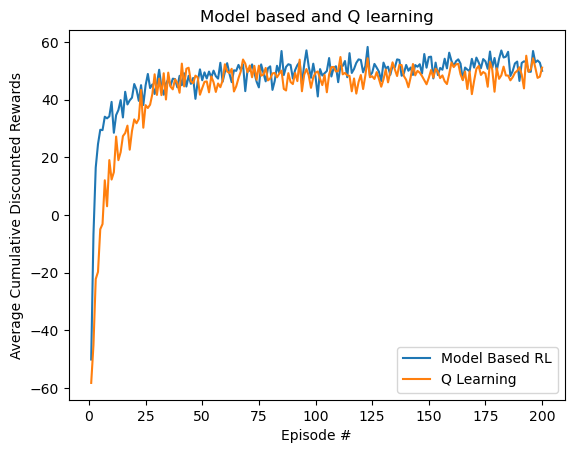

In [12]:
fig = plt.figure()
plt.title("Model based and Q learning")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Rewards")
# Test model-based RL
[V,policy] = rlProblem.modelBasedRL(s0=0,defaultT=np.ones([mdp.nActions,mdp.nStates,mdp.nStates])/mdp.nStates,initialR=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.05)
print("\nmodel-based RL results")
print("V : " + str(V))
print("Policy : " + str(policy))
print("\n")
# Test Q-learning
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.05)
print("\nQ-learning results")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")

plt.legend(loc='best')
plt.savefig('TestRL2_Graph1.png', bbox_inches='tight')
plt.show()
plt.close()

# Part 1-2
根據實驗結果:
1. Thompson Sampling: 表現最好，大部分時間都維持在最高的平均獎勵。
2. Epsilon-Greedy: 平均獎勵也有明顯的上升趨勢，但整體表現不如Thompson Sampling，因為其探索方式是隨機探索，因此數據利用效率較Thompson Sampling低。
3. UCB: 初期獎勵上升速度快，但最終收斂結果和Epsilon-Greedy差不多。因為UCB的結果非常仰賴於探索常數C的選擇，C 太大會導致過度探索，C 太小則探索不足，導致演算法表現不如理論的好。

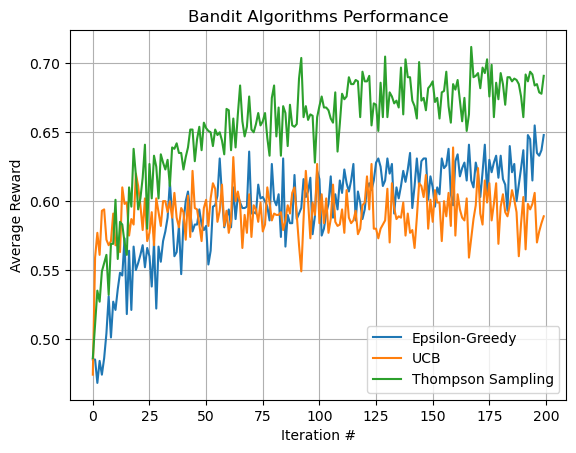

In [31]:
def sampleBernoulli(mean):
    ''' function to obtain a sample from a Bernoulli distribution

    Input:
    mean -- mean of the Bernoulli

    Output:
    sample -- sample (0 or 1)
    '''

    if np.random.rand(1) < mean: return 1
    else: return 0


# Multi-arm bandit problems (3 arms with probabilities 0.3, 0.5 and 0.7)
T = np.array([[[1]],[[1]],[[1]]])
R = np.array([[0.3],[0.5],[0.7]])
discount = 0.999

mdp = MDP.MDP(T,R,discount)
#mdp = MDP(T,R,discount)
banditProblem = RL2(mdp,sampleBernoulli)

trial = 1000
n_iterations = 200
rewards_greedy = np.zeros(n_iterations)
rewards_ucb = np.zeros(n_iterations)
rewards_thompson = np.zeros(n_iterations)


for i in range(trial):
  # Test epsilon greedy strategy
  _, rewards_g = banditProblem.epsilonGreedyBandit(nIterations=n_iterations)
  # Test Thompson sampling strategy
  _, rewards_t = banditProblem.thompsonSamplingBandit(prior=np.ones([mdp.nActions,2]),nIterations=n_iterations)
  # Test UCB strategy
  _, rewards_u = banditProblem.UCBbandit(nIterations=n_iterations)
  rewards_greedy += rewards_g
  rewards_ucb += rewards_u
  rewards_thompson += rewards_t

rewards_greedy /= trial
rewards_ucb /= trial
rewards_thompson /= trial
# 畫圖
import matplotlib.pyplot as plt
iterations = range(n_iterations)

plt.plot(iterations, rewards_greedy, label="Epsilon-Greedy")
plt.plot(iterations, rewards_ucb, label="UCB")
plt.plot(iterations, rewards_thompson, label="Thompson Sampling")

plt.xlabel("Iteration #")
plt.ylabel("Average Reward")
plt.title("Bandit Algorithms Performance")
plt.legend()
plt.grid(True)
plt.show()